## data analysis

In [4]:
INPUT_FILE = "metadata/train_metadata.json"
with open(INPUT_FILE, "r", encoding="utf-8") as f:
    data = json.load(f)

In [9]:
grouped = defaultdict(list)
for item in data:
    hl = item.get("hearing_loss", "Unknown")
    grouped[hl].append(item.get("correctness", 0))

# Compute average and median for each hearing_loss group
stats = {}
for hl, values in grouped.items():
    if values:  # avoid empty lists
        stats[hl] = {
            "average_words_correct": round(mean(values), 2),
            "median_words_correct": round(median(values), 2),
            "count": len(values)
        }
    else:
        stats[hl] = {"average_words_correct": 0, "median_words_correct": 0, "count": 0}

print(json.dumps(stats, indent=4))

{
    "Moderate": {
        "average_words_correct": 0.32,
        "median_words_correct": 0.2,
        "count": 2934
    },
    "Mild": {
        "average_words_correct": 0.4,
        "median_words_correct": 0.33,
        "count": 2935
    },
    "No Loss": {
        "average_words_correct": 0.58,
        "median_words_correct": 0.64,
        "count": 2933
    }
}


C:\Users\tygq\AppData\Local\Temp\ipykernel_4336\2520091488.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, showmeans=True)


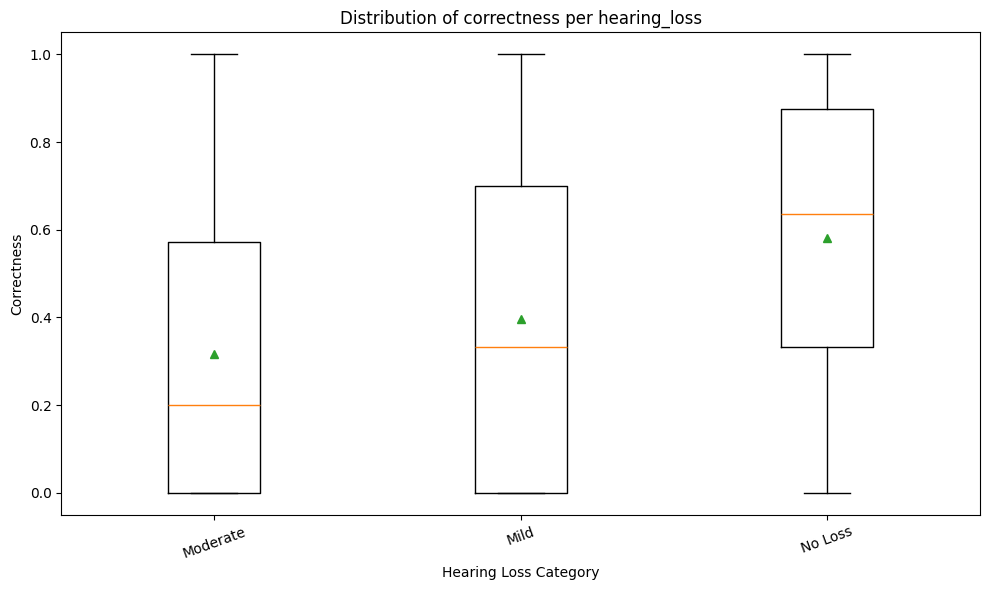

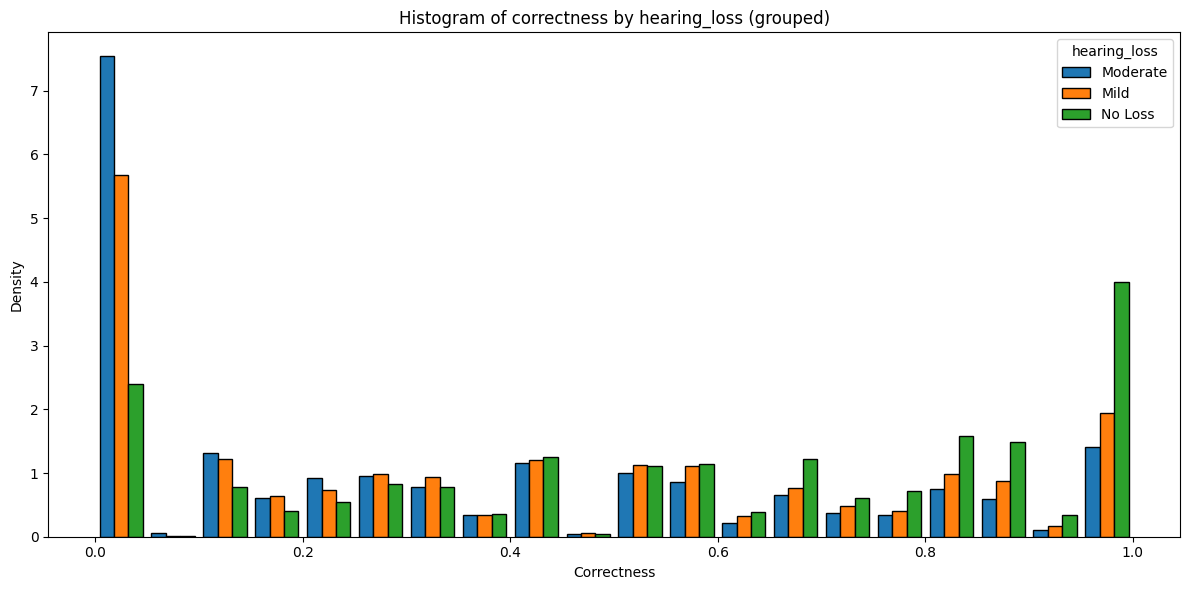

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Boxplot (ordered: Moderate, Mild, No Loss) ----------------
fig, ax = plt.subplots(figsize=(10, 6))

order = ["Moderate", "Mild", "No Loss"]
groups, labels = [], []

for hl in order:
    vals = pd.to_numeric(df.loc[df["hearing_loss"] == hl, "correctness"], errors="coerce").dropna().values
    if vals.size:
        groups.append(vals)
        labels.append(hl)

if groups:
    ax.boxplot(groups, labels=labels, showmeans=True)
    ax.set_title("Distribution of correctness per hearing_loss")
    ax.set_xlabel("Hearing Loss Category")
    ax.set_ylabel("Correctness")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()
else:
    plt.close()
    print("No correctness data available for boxplot.")


# ---------------- Grouped histogram (side-by-side bars per bin) ----------------
fig, ax = plt.subplots(figsize=(12, 6))

# Shared bin edges across ALL data
all_vals = pd.to_numeric(df["correctness"], errors="coerce").dropna().values
if all_vals.size == 0:
    plt.close()
    print("No correctness data available for histogram.")
else:
    n_bins = 20
    bin_edges = np.linspace(all_vals.min(), all_vals.max(), n_bins + 1)
    bin_width = np.diff(bin_edges)[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    # bar width split for 3 categories
    k = 3
    width = bin_width / (k + 0.6)  # small gap
    offsets = np.array([-width, 0.0, width])  # left, middle, right

    plotted = False
    for i, hl in enumerate(order):
        vals = pd.to_numeric(df.loc[df["hearing_loss"] == hl, "correctness"], errors="coerce").dropna().values
        if vals.size == 0:
            continue

        # histogram counts, convert to density like original (area=1)
        counts, _ = np.histogram(vals, bins=bin_edges)
        density = counts / (vals.size * bin_width)

        ax.bar(bin_centers + offsets[i], density, width=width, edgecolor="black", label=hl, align="center")
        plotted = True

    if plotted:
        ax.set_title("Histogram of correctness by hearing_loss (grouped)")
        ax.set_xlabel("Correctness")
        ax.set_ylabel("Density")
        ax.legend(title="hearing_loss")
        plt.tight_layout()
        plt.show()
    else:
        plt.close()
        print("No correctness data available for histogram.")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use your already-loaded JSON list `data`
df = pd.DataFrame(data)

# Ensure expected columns exist (won't overwrite if already present)
for col in [
    "signal","fma","original_prompt","prompt",
    "original_response","response","n_words",
    "words_correct","correctness","hearing_loss"
]:
    if col not in df.columns:
        df[col] = np.nan

# Helper to normalize text when comparing
def normalize_text(s: pd.Series) -> pd.Series:
    s = s.fillna("").astype(str).str.lower().str.strip()
    s = s.str.replace(r"\s+", " ", regex=True)  # collapse spaces
    return s


In [15]:
op = normalize_text(df["original_prompt"])
p  = normalize_text(df["prompt"])

prompt_diff_mask = op != p
prompt_diff_count = int(prompt_diff_mask.sum())
total = len(df)

# Responses: ignore rows where original_response == "#"
oraw = df["original_response"].fillna("").astype(str)
rr   = df["response"].fillna("").astype(str)

or_norm = normalize_text(oraw)
r_norm  = normalize_text(rr)

valid_resp_mask = oraw != "#"
resp_diff_mask = (or_norm != r_norm) & valid_resp_mask
resp_diff_count = int(resp_diff_mask.sum())
valid_resp_total = int(valid_resp_mask.sum())

print("=== Prompt & Response Comparison ===")
print(f"Total samples: {total}")
print(f"Different original_prompt vs prompt: {prompt_diff_count} ({prompt_diff_count/max(total,1):.2%})")
print(
    "Different original_response vs response (excluding '#'): "
    f"{resp_diff_count} / {valid_resp_total} ({resp_diff_count/max(valid_resp_total,1):.2%})"
)

# Show examples if differences exist (up to 5)
if prompt_diff_count > 0:
    display(df.loc[prompt_diff_mask, ["original_prompt", "prompt"]].head(5))

if resp_diff_count > 0:
    display(df.loc[resp_diff_mask, ["original_response", "response"]].head(5))


=== Prompt & Response Comparison ===
Total samples: 8802
Different original_prompt vs prompt: 2968 (33.72%)
Different original_response vs response (excluding '#'): 3509 / 7537 (46.56%)


,original_prompt,prompt
2,"the blind sleep, and the deaf and dumb sleep",the blind sleep and the deaf and dumb sleep
5,we slaves and we masters *flesh* *out* *beast*...,we slaves and we masters flesh out beast disas...
6,you're sleeping with a pig,you are sleeping with a pig
12,Banana run Looks like I'm pulling a banana run,banana run looks like i am pulling a banana run
16,It's a pretty crazy life,it is a pretty crazy life


,original_response,response
1,I don't know where it's all the same,i do not know where it is all the same
5,"We've finally done, we've not done, so please ...",we have finally done we have not done so pleas...
6,You're sleep with a pig,you are sleep with a pig
10,"Sorry, a let's keep sound, a let's keep sound",sorry a let us keep sound a let us keep sound
11,"one hour, bye-bye, bye-bye",one hour bye - bye bye - bye


### nwords' correctness

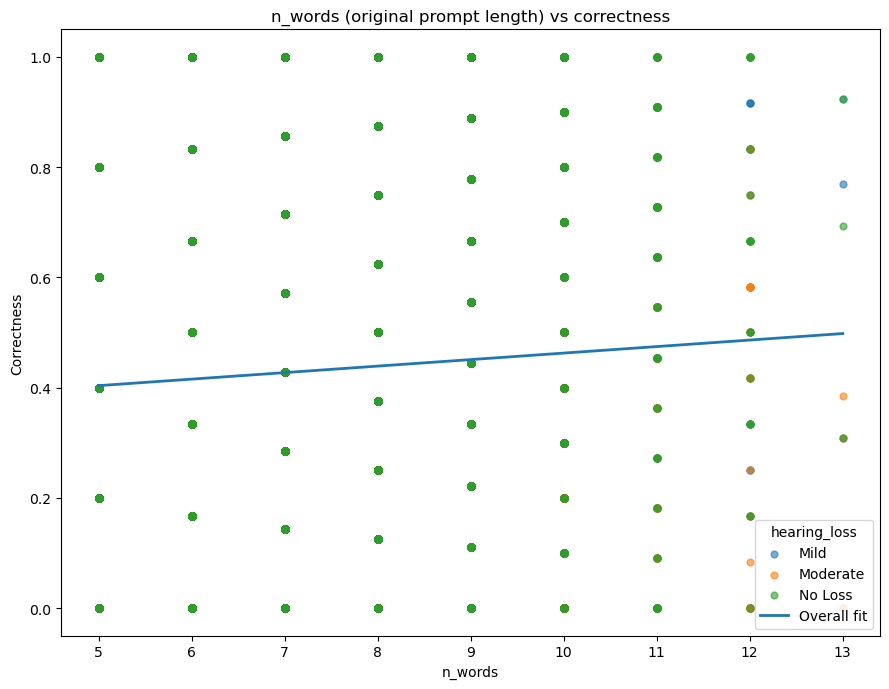

=== Correlations between n_words and correctness ===
Overall Pearson:  0.055
Overall Spearman: 0.061
- Mild: Pearson 0.080, Spearman 0.086 (n=2935)
- Moderate: Pearson 0.038, Spearman 0.051 (n=2934)
- No Loss: Pearson 0.056, Spearman 0.048 (n=2933)


In [16]:
# If any n_words are missing, compute from original_prompt as fallback
n_words = df["n_words"].copy()
if n_words.isna().any():
    fallback = df["original_prompt"].fillna("").astype(str).str.split().apply(len)
    n_words = n_words.fillna(fallback)

x = pd.to_numeric(n_words, errors="coerce")
y = pd.to_numeric(df["correctness"], errors="coerce")
hl = df["hearing_loss"].fillna("Unknown").astype(str)

valid = (~x.isna()) & (~y.isna())
xv = x[valid].to_numpy()
yv = y[valid].to_numpy()
hlv = hl[valid].to_numpy()

if xv.size == 0:
    print("No valid data for n_words vs correctness.")
else:
    # ---- Scatter by hearing_loss ----
    fig, ax = plt.subplots(figsize=(9, 7))
    categories = sorted(pd.unique(hlv))
    for cat in categories:
        mask = hlv == cat
        ax.scatter(xv[mask], yv[mask], alpha=0.6, label=str(cat), s=24)

    # ---- Overall linear fit (if variance exists) ----
    if np.std(xv) > 0:
        coef = np.polyfit(xv, yv, deg=1)
        lx = np.linspace(xv.min(), xv.max(), 100)
        ly = np.polyval(coef, lx)
        ax.plot(lx, ly, linewidth=2, label="Overall fit")

    ax.set_title("n_words (original prompt length) vs correctness")
    ax.set_xlabel("n_words")
    ax.set_ylabel("Correctness")
    ax.legend(title="hearing_loss")
    plt.tight_layout()
    plt.show()

    # ---- Correlations ----
    pearson = pd.Series(xv).corr(pd.Series(yv), method="pearson")
    spearman = pd.Series(xv).corr(pd.Series(yv), method="spearman")
    print("=== Correlations between n_words and correctness ===")
    print(f"Overall Pearson:  {pearson:.3f}")
    print(f"Overall Spearman: {spearman:.3f}")

    # Per-category correlations (only if at least 3 points)
    for cat in categories:
        mask = hlv == cat
        if mask.sum() >= 3 and np.std(xv[mask]) > 0:
            p = pd.Series(xv[mask]).corr(pd.Series(yv[mask]), method="pearson")
            s = pd.Series(xv[mask]).corr(pd.Series(yv[mask]), method="spearman")
            print(f"- {cat}: Pearson {p:.3f}, Spearman {s:.3f} (n={mask.sum()})")


In [18]:
dfc = df.copy()
dfc["correctness"] = pd.to_numeric(dfc["correctness"], errors="coerce")
if "n_words" not in dfc or dfc["n_words"].isna().any():
    dfc["n_words"] = dfc["original_prompt"].fillna("").astype(str).str.split().apply(len)
else:
    dfc["n_words"] = pd.to_numeric(dfc["n_words"], errors="coerce")

summary = (
    dfc.groupby("hearing_loss")
       .agg(
           count=("correctness", "count"),
           avg_correctness=("correctness", "mean"),
           median_correctness=("correctness", "median"),
           avg_n_words=("n_words", "mean"),
           median_n_words=("n_words", "median"),
       )
       .round(3)
       .reset_index()
)

summary


,hearing_loss,count,avg_correctness,median_correctness,avg_n_words,median_n_words
0,Mild,2935,0.396,0.333,7.319,7.0
1,Moderate,2934,0.317,0.200,7.318,7.0
2,No Loss,2933,0.580,0.636,7.318,7.0


### Phoneme anlaysis

In [19]:
import json
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use your already-loaded JSON list `data`
df = pd.DataFrame(data)

# Ensure CMU dictionary is available
try:
    nltk.data.find("corpora/cmudict")
except LookupError:
    nltk.download("cmudict")

# ---- text normalization helpers ----
_word_re = re.compile(r"[^\w']+")  # keep letters/digits/underscore and apostrophes (e.g., don't -> don't)

def normalize_text(s: str) -> str:
    if s is None:
        return ""
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

def tokenize_words(s: str) -> list:
    """
    Simple word tokenizer:
    - normalize case/whitespace
    - strip most punctuation but keep apostrophes
    """
    s = normalize_text(s)
    # replace non-word chars (except apostrophes) with space
    s = _word_re.sub(" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    if not s:
        return []
    return s.split(" ")


In [20]:
from nltk.corpus import cmudict

class PhonemeUtil:
    def __init__(self):
        # Load the CMU Pronouncing Dictionary
        self.pronouncing_dict = cmudict.dict()

    def get_phonemes(self, word):
        """Returns the phoneme sequence of a word."""
        word_lower = word.lower()
        pronunciations = self.pronouncing_dict.get(word_lower)
        if pronunciations is None:
            return ['<UNK>']
        phonemes = pronunciations[0]

        # remove digits
        clean_phonemes = []
        for phoneme in phonemes:
            clean_phoneme = re.sub(r'\d', '', phoneme)
            clean_phonemes.append(clean_phoneme)
        return clean_phonemes

    def word_to_phoneme_sequence(self, sentence):
        """Converts a word sequence to a phoneme sequence."""
        words = sentence.split(" ")
        phoneme_sequence = []
        for word in words:
            word_phonemes = self.get_phonemes(word)
            phoneme_sequence.extend(word_phonemes)
        return phoneme_sequence


class PhonemeTokenizer:
    def __init__(self):
        self.tokens = [
            '<blank>','AA','AE','AH','AO','AW','AY','B','CH','D','DH','EH','ER','EY','F','G',
            'HH','IH','IY','JH','K','L','M','N','NG','OW','OY','P','R','S','SH','T','TH','UH',
            'UW','V','W','Y','Z','ZH','<UNK>',
        ]
        self.token_to_id = {}
        self.id_to_token = {}
        self.vocab = set(self.tokens)
        for i, token in enumerate(self.tokens):
            self.token_to_id[token] = i
            self.id_to_token[i] = token

    def encode_seq(self, seq):
        encoded = []
        for phoneme in seq:
            encoded.append(self.token_to_id.get(phoneme, self.token_to_id['<UNK>']))
        return encoded

    def decode_seq(self, ids):
        decoded = []
        for id_val in ids:
            decoded.append(self.id_to_token.get(id_val, '<UNK>'))
        return decoded

    def decode_seq_batch(self, batch_ids):
        return [self.decode_seq(seq_ids) for seq_ids in batch_ids]


phoneme_util = PhonemeUtil()
tokenizer = PhonemeTokenizer()


In [21]:
OUTPUT_PHONEMES_FILE = "metadata/prompts_phonemes.json"

records_out = []
for row in data:
    prompt = row.get("prompt") or ""
    # Normalize/tokenize prompt for stable word handling
    words = tokenize_words(prompt)

    # phonemes per word (list[list[str]])
    word_phonemes = [phoneme_util.get_phonemes(w) for w in words]
    # flattened sequence
    flat_phonemes = [p for sub in word_phonemes for p in sub]
    # ids
    phoneme_ids = tokenizer.encode_seq(flat_phonemes)

    rec = {
        "signal": row.get("signal"),
        "hearing_loss": row.get("hearing_loss"),
        "prompt": prompt,
        "prompt_words": words,
        "word_phonemes": word_phonemes,  # parallel to prompt_words
        "phoneme_sequence": flat_phonemes,
        "phoneme_ids": phoneme_ids,
    }
    records_out.append(rec)

with open(OUTPUT_PHONEMES_FILE, "w", encoding="utf-8") as f:
    json.dump(records_out, f, ensure_ascii=False, indent=2)

print(f"[Saved] {OUTPUT_PHONEMES_FILE} with {len(records_out)} items")
# peek at first
if records_out:
    print(json.dumps(records_out[0], ensure_ascii=False, indent=2)[:800], "...")


[Saved] metadata/prompts_phonemes.json with 8802 items
{
  "signal": "c221f2084c780e8f212f4697",
  "hearing_loss": "Moderate",
  "prompt": "cos you better hold on",
  "prompt_words": [
    "cos",
    "you",
    "better",
    "hold",
    "on"
  ],
  "word_phonemes": [
    [
      "K",
      "AO",
      "S"
    ],
    [
      "Y",
      "UW"
    ],
    [
      "B",
      "EH",
      "T",
      "ER"
    ],
    [
      "HH",
      "OW",
      "L",
      "D"
    ],
    [
      "AA",
      "N"
    ]
  ],
  "phoneme_sequence": [
    "K",
    "AO",
    "S",
    "Y",
    "UW",
    "B",
    "EH",
    "T",
    "ER",
    "HH",
    "OW",
    "L",
    "D",
    "AA",
    "N"
  ],
  "phoneme_ids": [
    20,
    4,
    29,
    37,
    34,
    7,
    11,
    31,
    12,
    16,
    25,
    21,
    9,
    1,
    23
  ]
} ...


In [25]:
def greedy_align(ref_words: list[str], hyp_words: list[str], lookahead: int = 2):
    """
    Greedy alignment of reference (prompt) to hypothesis (response).
    At each step, prefer: exact match; else try single-step delete/insert;
    else lookahead up to `lookahead`; else take substitution.
    Returns list of (ref or None, hyp or None).
    """
    i, j = 0, 0
    n, m = len(ref_words), len(hyp_words)
    pairs = []

    while i < n or j < m:
        # if one side exhausted
        if i >= n and j < m:
            pairs.append((None, hyp_words[j])); j += 1; continue
        if j >= m and i < n:
            pairs.append((ref_words[i], None)); i += 1; continue

        rw, hw = ref_words[i], hyp_words[j]

        # 1) exact match
        if rw == hw:
            pairs.append((rw, hw)); i += 1; j += 1; continue

        # 2) single-step delete (skip ref) if next ref matches current hyp
        if i + 1 < n and ref_words[i+1] == hw:
            pairs.append((rw, None)); i += 1; continue

        # 3) single-step insert (skip hyp) if current ref matches next hyp
        if j + 1 < m and ref_words[i] == hyp_words[j+1]:
            pairs.append((None, hw)); j += 1; continue

        # 4) limited lookahead: try to sync within a small window
        matched = False
        for a in range(2, lookahead+1):
            if i + a < n and ref_words[i+a] == hw:
                # treat next (a) refs as deletions
                for k in range(a):
                    pairs.append((ref_words[i+k], None))
                i += a
                matched = True
                break
            if j + a < m and ref_words[i] == hyp_words[j+a]:
                # treat next (a) hyps as insertions
                for k in range(a):
                    pairs.append((None, hyp_words[j+k]))
                j += a
                matched = True
                break
        if matched:
            continue

        # 5) fallback: substitution
        pairs.append((rw, hw)); i += 1; j += 1

    return pairs


In [26]:
rows_wordlevel = []

for row in data:
    prompt = row.get("prompt") or ""
    response = row.get("response") or ""
    if not prompt.strip() or not response.strip():
        continue
    if row.get("original_response") == "#" and not response.strip():
        continue

    pw = tokenize_words(prompt)
    rw = tokenize_words(response)
    if not pw or not rw:
        continue

    aligned = greedy_align(pw, rw, lookahead=2)
    # keep only pairs where both sides exist (substitutions & matches)
    for ref_w, hyp_w in aligned:
        if ref_w is None or hyp_w is None:
            continue
        correct = int(ref_w == hyp_w)
        phs = phoneme_util.get_phonemes(ref_w)
        phoneme_count = len(phs)
        rows_wordlevel.append({
            "signal": row.get("signal"),
            "hearing_loss": row.get("hearing_loss"),
            "prompt_word": ref_w,
            "response_word": hyp_w,
            "is_correct": correct,
            "phoneme_count": phoneme_count,
            "is_unk": int(phs == ['<UNK>']),
        })

words_df = pd.DataFrame(rows_wordlevel)
print(f"greedy-aligned word-level rows: {len(words_df)}")
words_df.head()


greedy-aligned word-level rows: 45169


,signal,hearing_loss,prompt_word,response_word,is_correct,phoneme_count,is_unk
0,63de05fbfcab2d7748b83cb3,Mild,and,i,0,3,0
1,63de05fbfcab2d7748b83cb3,Mild,then,do,0,3,0
2,63de05fbfcab2d7748b83cb3,Mild,lower,not,0,3,0
3,63de05fbfcab2d7748b83cb3,Mild,it,it,1,2,0
4,63de05fbfcab2d7748b83cb3,Mild,down,is,0,3,0


,phoneme_count,accuracy,n
0,1,0.705069,3255
1,2,0.631379,15756
2,3,0.549407,13733
3,4,0.530767,6078
4,5,0.503468,3172
5,6,0.488429,1642
6,7,0.495389,759
7,8,0.493827,324
8,9,0.447674,172
9,10,0.510204,49


Pearson (phoneme_count vs is_correct):  -0.108
Spearman (phoneme_count vs is_correct): -0.120


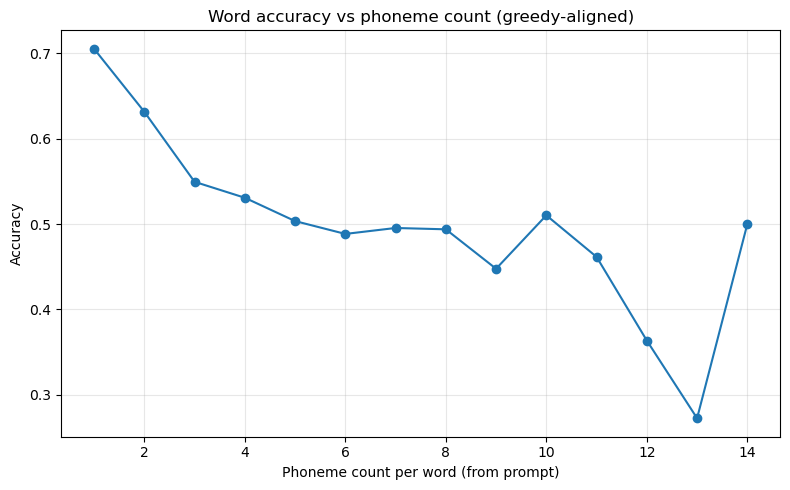

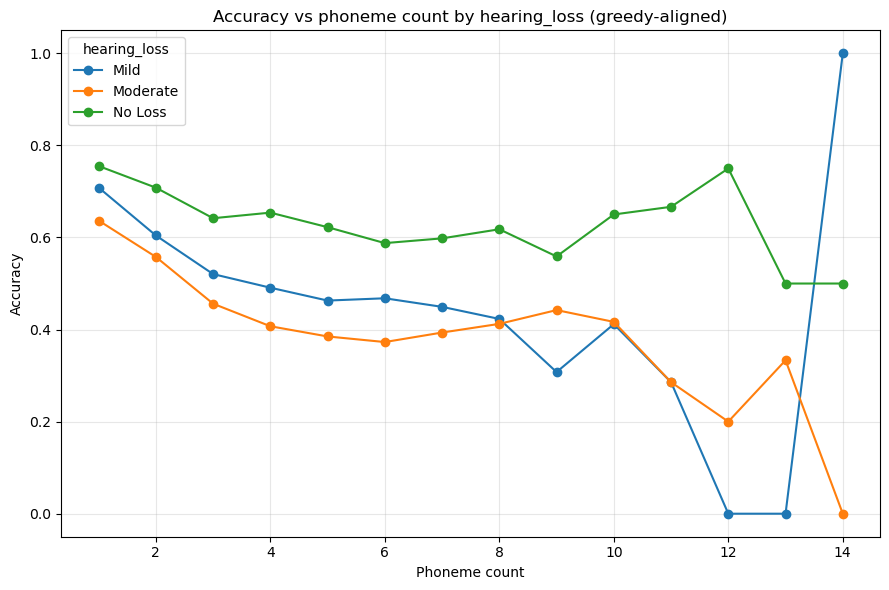

In [27]:
if len(words_df) == 0:
    print("No aligned word pairs to analyze.")
else:
    # Optionally drop UNK words (comment out to keep)
    keep_df = words_df[words_df["is_unk"] == 0].copy()

    acc_by_len = (
        keep_df.groupby("phoneme_count")["is_correct"]
               .agg(["mean","count"])
               .rename(columns={"mean":"accuracy","count":"n"})
               .reset_index()
               .sort_values("phoneme_count")
    )
    display(acc_by_len)

    # overall correlations
    pc = keep_df["phoneme_count"].astype(float)
    yc = keep_df["is_correct"].astype(float)
    pearson = pc.corr(yc, method="pearson")
    spearman = pc.corr(yc, method="spearman")
    print(f"Pearson (phoneme_count vs is_correct):  {pearson:.3f}")
    print(f"Spearman (phoneme_count vs is_correct): {spearman:.3f}")

    # plot accuracy curve
    plt.figure(figsize=(8,5))
    plt.plot(acc_by_len["phoneme_count"], acc_by_len["accuracy"], marker="o")
    plt.title("Word accuracy vs phoneme count (greedy-aligned)")
    plt.xlabel("Phoneme count per word (from prompt)")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # stratify by hearing loss (optional)
    grouped = (
        keep_df.groupby(["hearing_loss","phoneme_count"])["is_correct"]
               .mean()
               .reset_index()
               .sort_values(["hearing_loss","phoneme_count"])
    )
    plt.figure(figsize=(9,6))
    for hl, sub in grouped.groupby("hearing_loss"):
        plt.plot(sub["phoneme_count"], sub["is_correct"], marker="o", label=str(hl))
    plt.title("Accuracy vs phoneme count by hearing_loss (greedy-aligned)")
    plt.xlabel("Phoneme count")
    plt.ylabel("Accuracy")
    plt.legend(title="hearing_loss")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [28]:
# Select words with 10 or more phonemes
high_phoneme_df = words_df[words_df["phoneme_count"] >= 10].copy()

# Show basic stats
print(f"Found {len(high_phoneme_df)} words with ≥10 phonemes")
print(f"Unique words: {high_phoneme_df['prompt_word'].nunique()}")

# Display a few examples with context
display(
    high_phoneme_df[
        ["prompt_word", "response_word", "phoneme_count", "is_correct", "hearing_loss", "signal"]
    ].head(20)
)


Found 101 words with ≥10 phonemes
Unique words: 49


,prompt_word,response_word,phoneme_count,is_correct,hearing_loss,signal
183,unexpected,m,11,0,Mild,c16800a7b9597bcfa38e9c66
220,propaganda,propaganda,10,1,Moderate,5b1313fdfa403d632220ef66
468,propaganda,me,10,0,Mild,54c30b719da37621037aa2ad
740,propaganda,propaganda,10,1,No Loss,4cb6bec2d8a009347b79bcbe
822,unexpected,unexpected,11,1,No Loss,e2237be8caaf707953534be3
1199,ingredients,are,11,0,Moderate,d3a5e675c32fb11403e5caa7
2465,progressives,progressives,10,1,No Loss,52d32015a2be33af876fdb0d
2466,conservatives,conservatives,11,1,No Loss,52d32015a2be33af876fdb0d
2866,unpredictable,unpredictable,13,1,No Loss,2266d73c8ed7cd71025e0e40
2948,responsibility,me,14,0,No Loss,e0748ae33411bb4c64bfac31


## STOI

In [44]:
import numpy as np
import soundfile as sf
from pystoi import stoi

def read_mono(path):
    # Always get 2-D, then downmix if needed
    x, fs = sf.read(path, always_2d=True)
    # Downmix stereo/multichannel to mono
    x = x.mean(axis=1)  # shape -> (num_samples,)
    # Make sure dtype is float
    x = x.astype(np.float32, copy=False)
    return x, fs

clean, fs_c = read_mono('train/signals/90c0d82ded64766576a99459.flac')
denoised, fs_d = read_mono('train/unprocessed/90c0d82ded64766576a99459_unproc.flac')

# Use the same fs and same length
if fs_c != fs_d:
    raise ValueError(f"Sample rates differ: clean={fs_c}, denoised={fs_d}")
L = min(len(clean), len(denoised))
clean = clean[:L]
denoised = denoised[:L]

# Compute STOI (set extended=True if you want eSTOI)
d = stoi(clean, denoised, fs_c, extended=False)
print(d)


0.3516890028339529


In [43]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Singing-Adapted STOI (SA-STOI)
- Implements a faithful STOI-style pipeline:
  resample -> 1/3-octave filterbank -> envelopes -> clipping -> frame corr
- Averages only the TOP-3 one-third-octave bands (~2.4, 3.0, 4.3 kHz).
- Expects: reference = clean singing (ideally vocals-only), mixture = vocal+music.

Dependencies: numpy, scipy, soundfile, librosa
pip install numpy scipy soundfile librosa
"""

import numpy as np
import soundfile as sf
import librosa
from scipy.signal import butter, sosfiltfilt, hilbert
from typing import Tuple, List

# --------------------------
# Utility functions
# --------------------------

def load_mono_resample(path: str, target_sr: int = 10_000) -> Tuple[np.ndarray, int]:
    x, sr = sf.read(path)
    if x.ndim > 1:
        x = x.mean(axis=1)
    if sr != target_sr:
        x = librosa.resample(x.astype(np.float32), orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    # remove DC
    x = x - np.mean(x)
    # simple peak safeguard
    mx = np.max(np.abs(x)) + 1e-12
    if mx > 1.0:
        x = x / mx
    return x.astype(np.float32), sr

def rms_normalize(x: np.ndarray, target_db: float = -25.0) -> np.ndarray:
    rms = np.sqrt(np.mean(x**2) + 1e-12)
    if rms == 0:
        return x
    target_lin = 10.0**(target_db/20.0)
    g = target_lin / rms
    y = x * g
    # soft clip
    y = np.clip(y, -1.0, 1.0)
    return y

def gcc_phat_align(ref: np.ndarray, deg: np.ndarray, fs: int, max_shift_ms: float = 100.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Align deg to ref using a simple normalized cross-correlation (PHAT-like).
    """
    max_lag = int(max_shift_ms/1000.0 * fs)
    N = min(len(ref), len(deg))
    r = ref[:N]
    d = deg[:N]

    # Zero-mean
    r = r - r.mean()
    d = d - d.mean()

    # Compute xcorr in time domain (windowed)
    lags = np.arange(-max_lag, max_lag+1, dtype=int)
    best_lag = 0
    best_val = -np.inf
    # Normalize per-lag to reduce amplitude bias
    for lag in lags:
        if lag >= 0:
            rr = r[lag:]
            dd = d[:len(rr)]
        else:
            rr = r[:len(d)+lag]
            dd = d[-lag:len(d)]
        if len(rr) < fs // 10:  # need at least 0.1s
            continue
        num = np.dot(rr, dd)
        den = np.sqrt((np.dot(rr, rr) + 1e-12) * (np.dot(dd, dd) + 1e-12))
        val = num / den
        if val > best_val:
            best_val = val
            best_lag = lag

    # Shift 'deg' to align with 'ref'
    if best_lag > 0:
        d_aligned = np.pad(d, (best_lag, 0))[:len(r)]
        r_aligned = r
    elif best_lag < 0:
        r_aligned = r[-best_lag:]
        d_aligned = d[:len(r_aligned)]
    else:
        r_aligned, d_aligned = r, d

    L = min(len(r_aligned), len(d_aligned))
    return r_aligned[:L], d_aligned[:L]

# --------------------------
# STOI 1/3-octave filterbank
# --------------------------

def third_octave_centers(f0: float = 150.0, fmax: float = 4300.0) -> List[float]:
    """
    Standard STOI centers from ~150 Hz to 4.3 kHz spaced by factor 2^(1/3).
    """
    centers = []
    fc = f0
    k = 2**(1.0/3.0)
    while fc <= fmax * 1.001:
        centers.append(fc)
        fc *= k
    return centers

def third_octave_band_edges(fc: float) -> Tuple[float, float]:
    """
    1/3-oct band: [fc / k, fc * k] where k = 2^(1/6).
    """
    k = 2**(1.0/6.0)
    return fc / k, fc * k

def bandpass_sos_for_center(fs: int, fc: float) -> np.ndarray:
    f1, f2 = third_octave_band_edges(fc)
    # keep inside usable range
    f1 = max(50.0, f1)
    f2 = min(fs/2.0 - 50.0, f2)
    wp = [f1/(fs/2.0), f2/(fs/2.0)]
    sos = butter(4, wp, btype="bandpass", output="sos")
    return sos

# --------------------------
# STOI core (envelope corr)
# --------------------------

def stoi_envelope_corr(ref_b: np.ndarray, deg_b: np.ndarray, N: int = 384, hop: int = 192,
                       clip_db: float = 10.0) -> float:
    """
    Ref & deg are already per-band, zero-phase filtered.
    Do: analytic envelope -> local clipping -> z-norm -> frame-wise correlation -> average.
    Returns value in [0, 1].
    """
    # Analytic envelopes
    env_r = np.abs(hilbert(ref_b))
    env_d = np.abs(hilbert(deg_b))

    # STOI's "clipping": cap deg envelope relative to ref by ~10 dB
    # i.e., env_d <= env_r * (1 + 10^(-clip_db/20))  (approximate cap for degraded envelope)
    cap = (1.0 + 10.0**(-clip_db/20.0))
    env_d = np.minimum(env_d, env_r * cap)

    # Frame-level correlation
    corrs = []
    L = len(env_r)
    for start in range(0, L - N + 1, hop):
        xr = env_r[start:start+N]
        yd = env_d[start:start+N]
        # z-norm
        xr = (xr - xr.mean()) / (xr.std() + 1e-12)
        yd = (yd - yd.mean()) / (yd.std() + 1e-12)
        c = float(np.dot(xr, yd) / N)          # in [-1, 1]
        c01 = 0.5 * (np.clip(c, -1.0, 1.0) + 1.0)  # map to [0,1]
        corrs.append(c01)

    if len(corrs) == 0:
        return 0.0
    return float(np.mean(corrs))

def singing_adapted_stoi(ref: np.ndarray, deg: np.ndarray, fs: int = 10_000) -> float:
    """
    Compute SA-STOI by averaging correlation over the TOP-3 1/3-octave bands.
    """
    centers = third_octave_centers()
    # Keep only bands up to Nyquist
    centers = [fc for fc in centers if fc < (fs/2.0 - 100.0)]
    # Select TOP-3 (largest center freqs)
    centers = sorted(centers)[-3:]  # ≈ 2.4k, 3.0k, 4.3k @ fs=10k

    band_vals = []
    for fc in centers:
        sos = bandpass_sos_for_center(fs, fc)
        # zero-phase to avoid phase/lag issues
        rb = sosfiltfilt(sos, ref)
        db = sosfiltfilt(sos, deg)
        v = stoi_envelope_corr(rb, db, N=384, hop=192, clip_db=10.0)
        band_vals.append(v)

    if len(band_vals) == 0:
        return 0.0
    return float(np.mean(band_vals))

# --------------------------
# Public API
# --------------------------

def compute_sa_stoi(ref_path: str, mix_path: str) -> float:
    """
    ref_path: reference singing (ideally vocals-only)
    mix_path: mixture (vocals + instruments)
    """
    FS = 10_000
    ref, fs_r = load_mono_resample(ref_path, FS)
    mix, fs_m = load_mono_resample(mix_path, FS)

    # Leveling helps alignment and stability
    ref = rms_normalize(ref, -25.0)
    mix = rms_normalize(mix, -25.0)

    # Align mixture to reference
    ref_aln, mix_aln = gcc_phat_align(ref, mix, fs=FS, max_shift_ms=100.0)

    # Same length
    L = min(len(ref_aln), len(mix_aln))
    ref_aln = ref_aln[:L]
    mix_aln = mix_aln[:L]

    # SA-STOI
    score = singing_adapted_stoi(ref_aln, mix_aln, fs=FS)
    # Bound to [0,1]
    score = float(np.clip(score, 0.0, 1.0))
    return score

clean = 'train/signals/b43bc2b8182a3a0abc33af0c.flac'
denoised = 'train/unprocessed/b43bc2b8182a3a0abc33af0c_unproc.flac'
score = compute_sa_stoi(clean, denoised)
print(score)

0.9293074737906403


### STOI plot

In [1]:
import os
import json
import numpy as np
import pandas as pd
import soundfile as sf
from pystoi import stoi
import matplotlib.pyplot as plt
from tqdm import tqdm

def read_mono(path):
    """Read audio file and convert to mono float32 array."""
    x, fs = sf.read(path, always_2d=True)
    x = x.mean(axis=1).astype(np.float32, copy=False)
    return x, fs

def compute_stoi_pair(clean_path, noisy_path):
    """Compute STOI between clean and noisy signals."""
    clean, fs_c = read_mono(clean_path)
    noisy, fs_n = read_mono(noisy_path)
    if fs_c != fs_n:
        raise ValueError(f"Different sample rates: {fs_c} vs {fs_n}")
    L = min(len(clean), len(noisy))
    clean, noisy = clean[:L], noisy[:L]
    try:
        return stoi(clean, noisy, fs_c, extended=False)
    except Exception as e:
        print(f"Error computing STOI for {clean_path}: {e}")
        return np.nan

# Path to metadata
meta_path = "metadata/train_metadata.json"

with open(meta_path, "r", encoding="utf-8") as f:
    meta = json.load(f)

df = pd.DataFrame(meta)
df.head()


,signal,fma,original_prompt,prompt,original_response,response,n_words,words_correct,correctness,hearing_loss
0,c221f2084c780e8f212f4697,147301,cos you better hold on,cos you better hold on,#,,5,0,0.000000,Moderate
1,63de05fbfcab2d7748b83cb3,000649,And then lower it down again,and then lower it down again,I don't know where it's all the same,i do not know where it is all the same,6,1,0.166667,Mild
2,cf74c013a02d82d04254a910,022968,"the blind sleep, and the deaf and dumb sleep",the blind sleep and the deaf and dumb sleep,The blind sleep and the deaf under sleep,the blind sleep and the deaf under sleep,9,7,0.777778,No Loss
3,56f3fb4847d2c90f38e8e983,124993,a street a couple of cars and maybe some trees,a street a couple of cars and maybe some trees,#,,10,0,0.000000,Moderate
4,b2486a8e181f84acd2db4d61,001750,in my mind I can see is fine,in my mind i can see is fine,#,,8,0,0.000000,Moderate


In [2]:
signal_dir = "train/signals"
unproc_dir = "train/unprocessed"

stoi_scores = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    sid = row["signal"]
    clean_path = os.path.join(signal_dir, f"{sid}.flac")
    noisy_path = os.path.join(unproc_dir, f"{sid}_unproc.flac")

    if not (os.path.exists(clean_path) and os.path.exists(noisy_path)):
        stoi_scores.append(np.nan)
        continue

    score = compute_stoi_pair(clean_path, noisy_path)
    stoi_scores.append(score)

df["stoi"] = stoi_scores
df.to_csv("train_stoi_results.csv", index=False)
df.head()


100%|██████████████████████████████████████████████████████████████████████████████| 8802/8802 [11:31<00:00, 12.72it/s]


,signal,fma,original_prompt,prompt,original_response,response,n_words,words_correct,correctness,hearing_loss,stoi
0,c221f2084c780e8f212f4697,147301,cos you better hold on,cos you better hold on,#,,5,0,0.000000,Moderate,0.286865
1,63de05fbfcab2d7748b83cb3,000649,And then lower it down again,and then lower it down again,I don't know where it's all the same,i do not know where it is all the same,6,1,0.166667,Mild,0.537241
2,cf74c013a02d82d04254a910,022968,"the blind sleep, and the deaf and dumb sleep",the blind sleep and the deaf and dumb sleep,The blind sleep and the deaf under sleep,the blind sleep and the deaf under sleep,9,7,0.777778,No Loss,1.000000
3,56f3fb4847d2c90f38e8e983,124993,a street a couple of cars and maybe some trees,a street a couple of cars and maybe some trees,#,,10,0,0.000000,Moderate,0.246770
4,b2486a8e181f84acd2db4d61,001750,in my mind I can see is fine,in my mind i can see is fine,#,,8,0,0.000000,Moderate,0.275699


In [3]:
# Remove NaNs
df_valid = df.dropna(subset=["stoi"])

# Compute mean ± std per category
summary = df_valid.groupby("hearing_loss")["stoi"].agg(["mean", "std", "count"])
print(summary)


                  mean           std  count
hearing_loss                               
Mild          0.393182  1.018757e-01   2935
Moderate      0.390458  1.014427e-01   2934
No Loss       1.000000  1.332369e-15   2933


<Figure size 800x500 with 0 Axes>

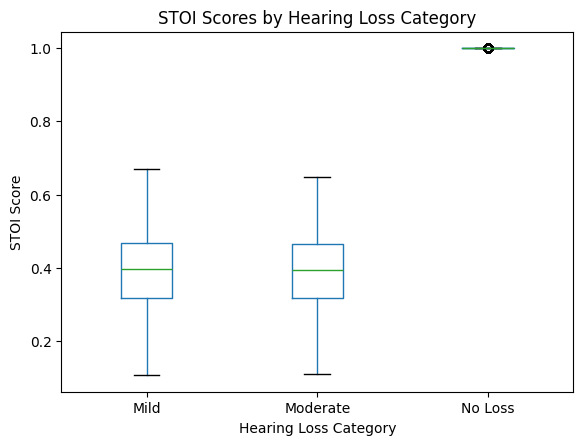

In [4]:
plt.figure(figsize=(8, 5))
df_valid.boxplot(column="stoi", by="hearing_loss", grid=False)
plt.title("STOI Scores by Hearing Loss Category")
plt.suptitle("")
plt.ylabel("STOI Score")
plt.xlabel("Hearing Loss Category")
plt.show()
